In [57]:
import os

import rasterio 
import rasterio.features
import rasterio.warp
from rasterio import mask
from rasterio.merge import merge
from rasterio.plot import show

import numpy as np

import matplotlib.pyplot as plt

In [58]:
REQUEST_AREA = "POLYGON ((6.2567138671875 51.57536261053028, 6.7160797119140625 51.57536261053028, 6.7160797119140625 51.78865666323309, 6.2567138671875 51.78865666323309, 6.2567138671875 51.57536261053028))"

floodmasks_geotiff = ["./test/result.tif"]

In [61]:
import math
import os 
from osgeo import gdal, osr

def get_extent(file):
    '''Returns min_x, min_y, max_x, max_y'''
    dataset = gdal.Open(file)
    geotrans = dataset.GetGeoTransform()
    return (geotrans[0],
            geotrans[3] + geotrans[5] * dataset.RasterYSize,
            geotrans[0] + geotrans[1] * dataset.RasterXSize,
            geotrans[3])

# loop through files and fetch bounding coordinates
min_x, max_x, min_y, max_y = (np.inf, -np.inf, np.inf, -np.inf)
for file in floodmasks_geotiff:
    ds_min_x, ds_min_y, ds_max_x, ds_max_y = get_extent(file)
    min_x = min(ds_min_x, min_x)
    max_x = max(ds_max_x, max_x)
    min_y = min(ds_min_y, min_y)
    max_y = max(ds_max_y, max_y)
    
min_x, max_x, min_y, max_y

(6.189930195400103, 6.7806623262371, 51.52158906851101, 51.84210796188486)

In [132]:
ds = gdal.Open(floodmasks_geotiff[0])
gt = list(ds.GetGeoTransform())

rows = math.ceil((max_y - min_y) / -gt[5])
columns = math.ceil((max_x - min_x) / gt[1])
print(f"cols={columns} rows={rows}")

# create new output
driver = gdal.GetDriverByName('gtiff')
out_ds = driver.Create('mosaic.tif', columns, rows, 1, gdal.GDT_Byte)
out_ds.SetProjection(ds.GetProjection())
# out_band
 
# change the upperleft coordinates
gt[0], gt[3] = min_x, max_y
out_ds.SetGeoTransform(gt)

data_arrays = []
for n, file in enumerate(floodmasks_geotiff):
    ds2 = gdal.Open(file)
    trans = gdal.Transformer(ds2, out_ds, [])
    success, xyz = trans.TransformPoint(False, 0, 0)
    x, y, z = map(int, xyz)
    
    data = ds2.GetRasterBand(1).ReadAsArray()
    
    
    output_array = np.zeros((rows, columns), dtype=np.int)
    output_array[y:y+data.shape[0], x:x+data.shape[1]] = data
    data_arrays.append(output_array)

summed_floodmask = np.sum(np.array(data_arrays), axis=0)

out_band = out_ds.GetRasterBand(1)
out_band.WriteArray(summed_floodmask)
out_band.FlushCache() 
out_band = None

out_ds = None

cols=6576 rows=3568


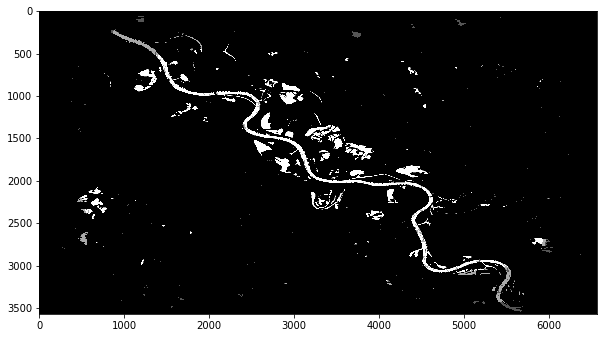

In [133]:
plt.figure(figsize=(10,15))
plt.imshow(summed_floodmask, cmap='gray')
plt.show()